In [1]:
%%capture
%pip install pandas
%pip install scikit-learn
%pip install tensorflow
%pip install matplotlib
%pip install nltk
%pip install seaborn
%pip install gensim

In [2]:
# Check if kernel has access to GPU
import tensorflow as tf
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  []


In [1]:
# Uncomment for google collab
# from google.colab import drive
# drive.mount('/content/drive')

# Change to desired path
# dataset_path = "/content/drive/My Drive/Colab Notebooks/AI/"
dataset_path = ""

In [2]:
import pandas as pd

# Import the dataset with consumer complaints
dataset_CC = pd.read_csv(dataset_path + "complaint_data.csv")

# Show columns as rows for better comprehension
print(dataset_CC.head(1).T)

                                                                             0
Date received                                                       08/09/2015
Product                                                       Credit reporting
Sub-product                                                                NaN
Issue                                   Incorrect information on credit report
Sub-issue                                              Information is not mine
Consumer complaint narrative                                               NaN
Company public response       Company chooses not to provide a public response
Company                                    Experian Information Solutions Inc.
State                                                                       NJ
ZIP code                                                                 08872
Tags                                                                       NaN
Consumer consent provided?                          

# PRE-PROCESSING

In [16]:
# Verify lines with empty columns
# It is important to mention that there are 4 relevant category columns, namely 'issue', 'Sub-product', 'Issue' and 'Sub-issue'
percent_missing = round(dataset_CC.isnull().sum() * 100 / len(dataset_CC), 2)
print(percent_missing.sort_values(ascending=False).head(20))

Tags                            86.37
Consumer complaint narrative    67.31
Company public response         62.76
Consumer disputed?              47.79
Consumer consent provided?      41.39
Sub-issue                       37.71
Sub-product                     15.98
ZIP code                         9.32
State                            1.66
Date sent to company             0.00
Timely response?                 0.00
Company response to consumer     0.00
Date received                    0.00
Submitted via                    0.00
Product                          0.00
Company                          0.00
Issue                            0.00
Complaint ID                     0.00
dtype: float64


In [34]:
# Select relevant columns
dataset_CC = dataset_CC[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative','Company public response']].copy()

# Rename columns to improve readability
dataset_CC.columns = ['product','sub_product', 'issue', 'sub_issue', 'consumer_complaint','company_response'] 

# Delete all lines without consumer complaint narrative which is the text associated with the ticket
# This step is crucial because we are gonna use this text to infer the previously mentioned categories.
print(f"Raw Length: {len(dataset_CC)}\n")

dataset_CC = dataset_CC.dropna(subset=['consumer_complaint'])
print(f"New Length: {len(dataset_CC)}\n")
print(dataset_CC.head(1))

Raw Length: 1471766

New Length: 481087

       product sub_product             issue sub_issue  \
4  Credit card         NaN  Billing disputes       NaN   

                                  consumer_complaint company_response  
4  I am dissatisfied with the current outcome of ...              NaN  


In [36]:
# Analyse the unique company responses to consumers
print(f"Unique Company Responses to Consumers: {len(dataset_CC['company_response'].unique())}\n")
pd.DataFrame(dataset_CC['company_response'].unique()[:15])

Unique Company Responses to Consumers: 11



,0
0,NaN
1,Company has responded to the consumer and the ...
2,Company believes complaint caused principally ...
3,Company chooses not to provide a public response
4,Company disputes the facts presented in the co...
5,Company believes the complaint is the result o...
6,Company believes it acted appropriately as aut...
7,Company can't verify or dispute the facts in t...
8,Company believes complaint is the result of an...
9,Company believes complaint represents an oppor...


In [37]:
# Analyse the unique values for category 'product'
print(f"Unique Products: {len(dataset_CC['product'].unique())}\n")
pd.DataFrame(dataset_CC['product'].unique()[:15])

Unique Products: 18



,0
0,Credit card
1,"Credit reporting, credit repair services, or o..."
2,Debt collection
3,Credit card or prepaid card
4,Mortgage
5,Bank account or service
6,Credit reporting
7,Student loan
8,Checking or savings account
9,Vehicle loan or lease


In [38]:
# Rename similar labels of category 'product' to reduce redundancy
dataset_CC.replace({'product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting, repair, or other', 
             'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

# Check new unique values
print(f"Unique Products: {len(dataset_CC['product'].unique())}\n")
pd.DataFrame(dataset_CC['product'].unique()[:15])

Unique Products: 13



,0
0,Credit card or prepaid card
1,"Credit reporting, repair, or other"
2,Debt collection
3,Mortgage
4,Bank account or service
5,Student loan
6,Checking or savings account
7,Vehicle loan or lease
8,"Money transfer, virtual currency, or money ser..."
9,Consumer Loan


In [39]:
# Analyse the unique values for category 'sub_product'
print(f"Unique Sub_products: {len(dataset_CC['sub_product'].unique())}\n")
pd.DataFrame(dataset_CC['sub_product'].unique()[:15])

Unique Sub_products: 76



,0
0,NaN
1,Credit reporting
2,I do not know
3,General-purpose credit card or charge card
4,FHA mortgage
5,Credit card debt
6,Conventional home mortgage
7,Checking account
8,Store credit card
9,"Other (i.e. phone, health club, etc.)"


In [40]:
# Rename similar labels of category 'sub_product' to reduce redundancy
dataset_CC.replace({'sub_product': 
             {'Federal student loan servicing': 'Federal student loan',
             'Gift card': 'Gift or merchant card',
             '(CD) Certificate of deposit': 'CD (Certificate of Deposit)',
             }}, 
            inplace= True)

# Fill NaN values with a string value "Not Available"
dataset_CC = dataset_CC.fillna("Not Available")

# Check new unique values
print(f"Unique Sub_products: {len(dataset_CC['sub_product'].unique())}\n")
pd.DataFrame(dataset_CC['sub_product'].unique()[:15])

Unique Sub_products: 73



,0
0,Not Available
1,Credit reporting
2,I do not know
3,General-purpose credit card or charge card
4,FHA mortgage
5,Credit card debt
6,Conventional home mortgage
7,Checking account
8,Store credit card
9,"Other (i.e. phone, health club, etc.)"


In [41]:
# Analyse the unique values for category 'issue'
print(f"Unique Issues: {len(dataset_CC['issue'].unique())}\n")
pd.DataFrame(dataset_CC['issue'].unique()[:15])

Unique Issues: 161



,0
0,Billing disputes
1,Incorrect information on your report
2,Attempts to collect debt not owed
3,Improper use of your report
4,Problem with a purchase shown on your statement
5,"Loan modification,collection,foreclosure"
6,False statements or representation
7,Trouble during payment process
8,Deposits and withdrawals
9,Problem when making payments


In [43]:
# Analyse the unique values for category 'Sub-issue'
print(f"Unique Sub_issues: {len(dataset_CC['sub_issue'].unique())}\n")
pd.DataFrame(dataset_CC['sub_issue'].unique()[:15])

Unique Sub_issues: 217



,0
0,Not Available
1,Information belongs to someone else
2,Debt was result of identity theft
3,Credit inquiries on your report that you don't...
4,Credit card company isn't resolving a dispute ...
5,Public record information inaccurate
6,Attempted to collect wrong amount
7,You never received your bill or did not know a...
8,Debt was paid
9,Information is not mine


In [45]:
# Get unique combinations of classification columns
unique_classification_combinations = dataset_CC[['product', 'sub_product', 'issue', 'sub_issue']].value_counts()

print(unique_classification_combinations.head(5))

product                             sub_product       issue                                                                             sub_issue                                               
Credit reporting, repair, or other  Credit reporting  Incorrect information on your report                                              Information belongs to someone else                         30960
                                                      Problem with a credit reporting company's investigation into an existing problem  Their investigation did not fix an error on your report     26321
                                                      Incorrect information on your report                                              Account status incorrect                                    14457
                                                                                                                                        Account information incorrect                               14120

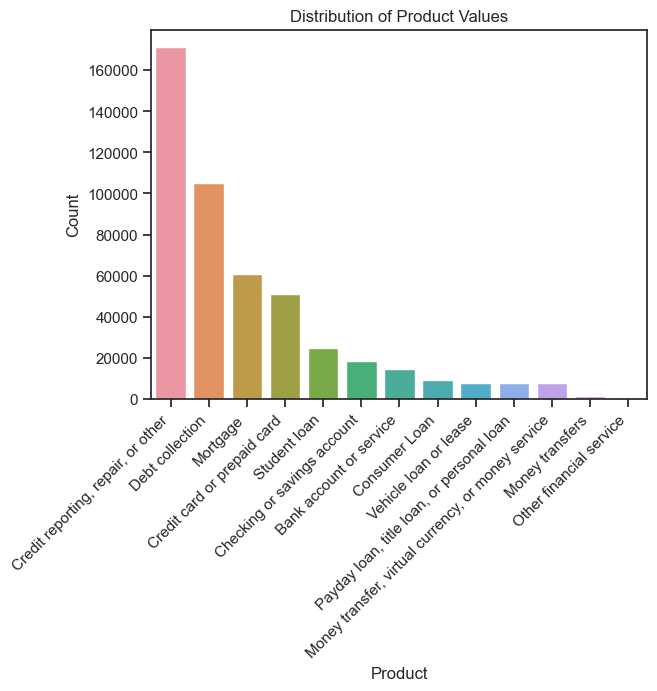

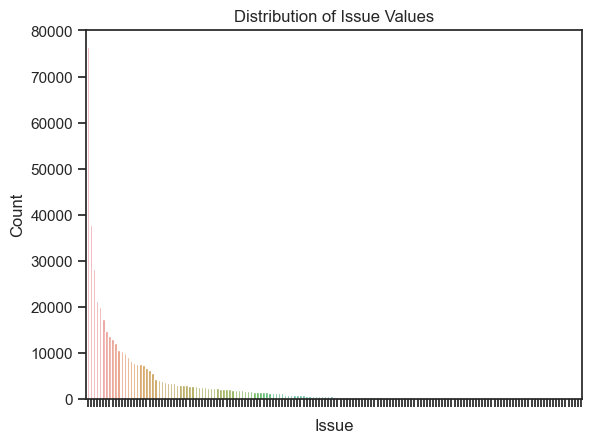

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

# Plot distribution of values for 'product'
sns.set(style="ticks")
ax = sns.countplot(x='product', data=dataset_CC, order=dataset_CC['product'].value_counts().index)
ax.set_title('Distribution of Product Values')
ax.set_xlabel('Product')
ax.set_ylabel('Count')
ax.set_xticklabels(dataset_CC['product'].value_counts().index, rotation=45, ha='right')
plt.show()

# Plot distribution of values for 'issue'
sns.set(style="ticks")
ax = sns.countplot(x='issue', data=dataset_CC, order=dataset_CC['issue'].value_counts().index)
ax.set_title('Distribution of Issue Values')
ax.set_xlabel('Issue')
ax.set_ylabel('Count')
ax.set_xticklabels([])
plt.show()

# CLASS PRE-PROCESSING

In [62]:
# Pre-processing of category columns
import numpy as np

# Convert categorical labels to numbers
y = pd.get_dummies(dataset_CC['product']).values
#y_product = pd.get_dummies(dataset_CC['product']).values
#y_sub_product = pd.get_dummies(dataset_CC['sub_product']).values
#y_issue = pd.get_dummies(dataset_CC['issue']).values
#y_sub_issue = pd.get_dummies(dataset_CC['sub_issue']).values

# Concatenate the dummy variables horizontally to create a single array
#y =  np.concatenate([y_product, y_sub_product, y_issue, y_sub_issue], axis=1)

# Check final shape of y tensor
print('Shape of label tensor:', y.shape)

# Extract number of classes for each category
num_classes_product = len(dataset_CC['product'].unique())
num_classes_sub_product = len(dataset_CC['sub_product'].unique())
num_classes_issue = len(dataset_CC['issue'].unique())
num_classes_sub_issue = len(dataset_CC['sub_issue'].unique())

print(num_classes_product)
print(num_classes_sub_product)
print(num_classes_issue)
print(num_classes_sub_issue)

Shape of label tensor: (481087, 464)
13
73
161
217


In [63]:
# Verify that there are existing stop words, punctuation, special symbols and 'xxxx' placeholders in the consumer complaints
print(dataset_CC['consumer_complaint'].iloc[12])

The debt in question was paid in XXXX 2014 and is still being reported to the XXXX gathering agencies as an open collection account. Proof of payment has been provided to the agency and they have failed to respond or correct the reporting. The accounts being reported as a balance owed to XXXX XXXX XXXX XXXX but the balance was paid to ChexSystems XXXX, who XXXX XXXX XXXX XXXX referred the matter to as well, meaning the same account was referred to XXXX ( XXXX ) separate agencies for collections, which I believe is defined as overshadowing.


# DATA/TEXT PRE-PROCESSING

In [65]:
# Uncomment if not previously installed
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords

# Reset index from zero
dataset_CC = dataset_CC.reset_index(drop=True)

# Remove all special symbols
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')

# Remove everything besides letters
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

# Define stop words to remove
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    # Lower case the text
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    # Remove existing 'xxxx' placeholders of text complaints
    text = text.replace('x', '')
    # Replace numbers with 'num' token
    # This will preserve the information that there was a number in the text without causing errors
    #text = text.replace('\d+', 'num')
    # Remove stop words and tokenize text complaints
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

dataset_CC['consumer_complaint'] = dataset_CC['consumer_complaint'].apply(clean_text)
dataset_CC['consumer_complaint'] = dataset_CC['consumer_complaint'].str.replace('\d+', '')

# Verify that stop words, punctuation, special symbols and 'xxxx' placeholders have been removed
print(dataset_CC['consumer_complaint'].iloc[12])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\silve\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
C:\Users\silve\AppData\Local\Temp\ipykernel_14984\2006627417.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset_CC['consumer_complaint'] = dataset_CC['consumer_complaint'].str.replace('\d+', '')


debt question paid  still reported gathering agencies open collection account proof payment provided agency failed respond correct reporting accounts reported balance owed balance paid chesystems referred matter well meaning account referred separate agencies collections believe defined overshadowing


In [66]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define max number of words to mantain in the vocabulary
MAX_WORDS = 50000

# Define max number of words to use per complaint
MAX_WORDS_COMPLAINT = 2500

# Define vector size per word
VECTOR_SIZE = 100

# Create tokenizer for text complaints, replacing all missing words in the vocabulary with oov token
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>", lower=True)
tokenizer.fit_on_texts(dataset_CC['consumer_complaint'].values) 

# Check number of unique tokens
print('Found %s unique tokens.' % len(tokenizer.word_index))

# Tokenize each token/word
# This receives a list of tokens/words and returns a list of corresponding indexes, where the smallest index represents the most used word
X = tokenizer.texts_to_sequences(dataset_CC['consumer_complaint'].values)

# Pad sequences to the same length (with 0s)
X = pad_sequences(X, maxlen=MAX_WORDS_COMPLAINT)

# Check final shape of X tensor
print('Shape of data tensor:', X.shape)

Found 164607 unique tokens.
Shape of data tensor: (481087, 2500)


In [16]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from transformers import BertTokenizer, TFBertModel

# # Define max number of words to maintain in the vocabulary
# MAX_WORDS = 50000

# # Define max number of words to use per complaint
# MAX_WORDS_COMPLAINT = 2500

# # Tokenize input text using BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# X = tokenizer(np.array(X), truncation=True, padding=True, max_length=MAX_WORDS_COMPLAINT, return_tensors='tf')

# # Load pre-trained BERT model
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# # Extract BERT embeddings
# embedding_matrix = bert_model.get_input_embeddings().numpy()

# # Get vector size per word according to tokenizer
# VECTOR_SIZE = tokenizer.hidden_size

# print(X.shape)
# print(embedding_matrix.shape)
# print(VECTOR_SIZE)

In [ ]:
# import numpy as np
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from gensim.models import Word2Vec

# # Define max number of words to mantain in the vocabulary
# MAX_WORDS = 50000

# # Define max number of words to use per complaint
# MAX_WORDS_COMPLAINT = 2500

# # Define vector size per word
# VECTOR_SIZE = 100

# # Train a Word2Vec model on text data
# w2v_model = Word2Vec(X, vector_size=VECTOR_SIZE, min_count=1)

# # Tokenize text complaints
# tokenizer = Tokenizer(num_words=MAX_WORDS)
# tokenizer.fit_on_texts(X)

# # Convert text data to sequences
# X = tokenizer.texts_to_sequences(X)

# # Pad sequences to the same length
# X = pad_sequences(X, maxlen=MAX_WORDS_COMPLAINT)

# print(X.shape)

# # Extract Word2Vec embeddings
# word_index = tokenizer.word_index
# MAX_WORDS = min(MAX_WORDS, len(word_index))
# embedding_matrix = np.zeros((MAX_WORDS, VECTOR_SIZE))
# for word, i in word_index.items():
#     if i >= MAX_WORDS:
#         continue
#     if word in w2v_model.wv:
#         embedding_vector = w2v_model.wv[word]
#         embedding_matrix[i] = embedding_vector

# print(embedding_matrix.shape)

# Training

In [67]:
# Uncomment for debugging purposes, such as the model training
# X=X[:100000]
# y=y[:100000]
# print(X.shape, y.shape)

(100000, 2500) (100000, 464)


In [69]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(90000, 2500) (90000, 464)
(10000, 2500) (10000, 464)


# MODELS

## Custom Loss Function for Multi-Category and Multi-Label Classification

In [43]:
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K

# Define the loss weights for each output class to be classified
output_weights = [1.0, 0.5, 0.75, 0.25]

# Define the custom loss function with weights
def weighted_loss(weights):
    # Convert weights to a Keras tensor
    weights_tensor = K.constant(weights)
    
    # Define the loss function
    def loss(y_true, y_pred):
        # Reshape y_true to desired shape (None, 1)
        #y_true_reshaped = tf.reshape(y_true, (-1, 1))
        # Compute the weighted loss
        loss = CategoricalCrossentropy(from_logits=False)(y_true, y_pred)
        weighted_loss = loss * weights_tensor
        
        # Return the weighted loss
        return weighted_loss
    
    # Return the loss function
    return loss

## LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Embedding, Dense

def getLSTMModel():
    # Sequential Model because the LSTM model is a NN which learns by data sequences
    model = Sequential()

    # Embedding Layer 
    # This is used to define the max words in the vocabulary, the max words per complaint and the vetor size per word
    model.add(Embedding(MAX_WORDS, VECTOR_SIZE, input_length=MAX_WORDS_COMPLAINT))
    # Embedding layer with pre-trained embeddings
    #model.add(Embedding(input_dim=MAX_WORDS, output_dim=VECTOR_SIZE, input_length=MAX_WORDS_COMPLAINT, weights=[embedding_matrix], trainable=False))

    # LSTM Layer
    # Dropout is a hyperparameter for turning off some neurons which helps avoiding overfitting
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0))

    # In the following code, each class is has a dense layer that is added after the convolutional layer to further process the features extracted 
    # by the convolutional layer. Before extracting the outputs, each of this dense layers uses dropout.
    # Dropout is a regularization technique used to prevent overfitting in neural networks
    # It works by randomly dropping out (i.e., setting to zero) a certain percentage of neurons during training.
    # This helps to prevent the network from relying too heavily on any one set of neurons,
    # and encourages it to learn more robust features that are useful for making predictions on new data.
    # Finally, each class layer goes through a softmax activation layer which converts a numbers vector to a probabilistic vector, 
    # where the neuron with the highest probability is chosen

    # product class output layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes_product, activation='softmax'))

    # Compile the model with the custom loss function
    # The loss function is used for training to evaluate the difference between neural network predictions and actual outputs 
    # The optimizer is the optimization algorithm that will be used for the adjustment of neural network weights during training
    model.compile(optimizer='adam',
                loss=[weighted_loss(output_weights[0])],
                metrics=['accuracy'])

    return model

# check model architecture
getLSTMModel().summary()

## CNN

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, Embedding, Dense

def getCNNModel():
    # Sequential Model because the LSTM model is a NN which learns by data sequences
    model = Sequential()

    # Embedding Layer 
    # This is used to define the max words in the vocabulary, the max words per complaint and the vetor size per word
    model.add(Embedding(MAX_WORDS, VECTOR_SIZE, input_length=MAX_WORDS_COMPLAINT))
    # Embedding layer with pre-trained embeddings
    #model.add(Embedding(input_dim=MAX_WORDS, output_dim=VECTOR_SIZE, input_length=MAX_WORDS_COMPLAINT, weights=[embedding_matrix], trainable=False))

    # Convolutional layer so the model is trained to learn more complex and abstract features from the input text.
    # Convolutional layers are commonly used in natural language processing tasks because they can extract patterns and features 
    # from the text data in a more efficient way than a fully connected layer.
    # In this case, the convolutional layer takes the embedded input text tensor and applies a convolution operation to it with multiple filter sizes. 
    # Each filter size captures different n-gram patterns in the input text, such as bigrams or trigrams, 
    # which helps the model to learn more about the structure and meaning of the text.
    # After applying the convolutional operation, a max pooling layer is added to extract the most important information
    # from the resulting feature maps. This helps to reduce the size of the feature maps and makes the model more computationally efficient.
    # In the last convolutional operation, a global max pooling layer is used because it works as both a max pooling layer and a flatten layer 
    # so the output of the pooling layer is flattened and passed through a dense layer, which learns to map the extracted features to the output classes.
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())

    # In the following code, each class is has a dense layer that is added after the convolutional layer to further process the features extracted 
    # by the convolutional layer. Before extracting the outputs, each of this dense layers uses dropout.
    # Dropout is a regularization technique used to prevent overfitting in neural networks
    # It works by randomly dropping out (i.e., setting to zero) a certain percentage of neurons during training.
    # This helps to prevent the network from relying too heavily on any one set of neurons,
    # and encourages it to learn more robust features that are useful for making predictions on new data.
    # Finally, each class layer goes through a softmax activation layer which converts a numbers vector to a probabilistic vector, 
    # where the neuron with the highest probability is chosen

    # product class output layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes_product, activation='softmax'))

    # # sub_product subclass output layer
    # Add a Concatenate layer to concatenate the input with the output from parent class, product
    # concatenate_layer = tf.keras.layers.concatenate([flatten_layer, product_output])
    # dense_layer2 = Dense(units=256, activation='relu')(concatenate_layer)
    # dropout2 = Dropout(rate=0.5)(dense_layer2)
    # sub_product_output = Dense(units=num_classes_sub_product, activation='softmax')(dropout2)

    # # issue class output layer
    # dense_layer3 = Dense(units=256, activation='relu')(flatten_layer)
    # dropout3 = Dropout(rate=0.5)(dense_layer3)
    # issue_output = Dense(units=num_classes_issue, activation='softmax')(dropout3)

    # # sub_issue subclass output layer
    # # Add a Concatenate layer to concatenate the input with the output from parent class, issue
    # concatenate_layer2 = tf.keras.layers.concatenate([flatten_layer, issue_output])
    # dense_layer4 = Dense(units=256, activation='relu')(concatenate_layer2)
    # dropout4 = Dropout(rate=0.5)(dense_layer4)
    # sub_issue_output = Dense(units=num_classes_sub_issue, activation='softmax')(dropout4)

    # Compile the model with the custom loss function
    # The loss function is used for training to evaluate the difference between neural network predictions and actual outputs 
    # The optimizer is the optimization algorithm that will be used for the adjustment of neural network weights during training
    model.compile(optimizer='adam',
                loss=[weighted_loss(output_weights[0])],
                metrics=['accuracy'])

    return model


# check model architecture
getCNNModel().summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 2500)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 2500, 100)    5000000     ['input_5[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 2496, 256)    128256      ['embedding_4[0][0]']            
                                                                                                  
 max_pooling1d_12 (MaxPooling1D  (None, 1248, 256)   0           ['conv1d_12[0][0]']              
 )                                                                                          

### Callbacks

In [68]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, Callback

# Define the training progress tracker callback
# This will help track the training progress of the model during runtime
class ProgressTrackerCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print("Epoch {} starts".format(epoch+1))

    def on_epoch_end(self, epoch, logs=None):
        print("Epoch {} ends".format(epoch+1))

    def on_train_batch_begin(self, batch, logs=None):
        print("Training batch {} starts".format(batch+1))

    def on_train_batch_end(self, batch, logs=None):
        print("Training batch {} ends".format(batch+1))

    def on_test_batch_begin(self, batch, logs=None):
        print("Testing batch {} starts".format(batch+1))

    def on_test_batch_end(self, batch, logs=None):
        print("Testing batch {} ends".format(batch+1))

# Define the learning rate range test callback
# This will plot the learning rate vs. loss curve, which can be used to choose a good learning rate.
# The learning rate should be chosen as the point where the loss is still decreasing but has not yet started to increase sharply. 
# In practice, this is often a learning rate that is one or two orders of magnitude smaller than the point of maximum slope in the curve.
class LearningRateFinder(LearningRateScheduler):
    def __init__(self, start_lr=1e-5, end_lr=10, num_iter=100):
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LearningRateFinder, self).__init__(self.lr_schedule)
        
    def lr_schedule(self, epoch):
        return self.start_lr + epoch * (self.end_lr - self.start_lr) / self.num_iter
    
    def on_train_begin(self, logs={}):
        self.lrates = []
        self.losses = []
        
    def on_batch_end(self, batch, logs={}):
        lr = self.model.optimizer.lr
        self.lrates.append(lr)
        loss = logs.get('loss')
        self.losses.append(loss)

# Training

In [ ]:
# Define hyperparameters
batch_size = 128
epochs = 5

# Train the model using the learning rate range test callback
lr_finder = LearningRateFinder()

# Train the model using the progress tracker callback
progress_tracker = ProgressTrackerCallback()

# Early stopping is a technique used to prevent overfitting during model training. 
# It monitors the performance of the model on a validation set during training, and if the performance does not improve 
# for a certain number of epochs, the training is stopped early.
# This can help save time and resources during training, and prevent overfitting to the training set.
early_stopping = EarlyStopping(
    monitor='val_loss', # quantity to be monitored
    #mode='min', # minimize the quantity monitored
    patience=3, # number of epochs with no improvement after which training will be stopped
    verbose=1, # logging mode
    #restore_best_weights=True, # restore the weights from the epoch with the best value of the monitored quantity
    min_delta=0.0001
)

# Choose desired model
#model = getLSTMModel()
model = getCNNModel()

# Fit the model
# Choose desired percentage for validation split
# This means that X% of training data will be used for validation
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[
                        #lr_finder, 
                        #progress_tracker,
                        early_stopping])

In [ ]:
# Save the pre-trained model to use for future predictions
#model.save('categorization_model_lstm')
model.save('categorization_model_cnn')

# Validation Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Uncomment if ran without training and choose desired model
#from tensorflow.keras.models import load_model
#model = load_model('categorization_model_cnn')

# Plot training & validation accuracy values over the number of epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values over the number of epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Test Analysis

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('categorization_model_cnn')

# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert predicted values back to categorical labels
y_pred_labels = []
for i in range(len(y_pred)):
    labels = []
    for j in range(4):
        labels.append(np.argmax(y_pred[i][j]))
    y_pred_labels.append(labels)

# Print the predicted labels for the first 10 test samples
print(y_pred_labels[:10])